In [2]:
import collections
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
# import tensorboard
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from EarlyStopping import EarlyStopping
from collections import OrderedDict

In [3]:

imgTrans = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

trainValset = ImageFolder("./Datasets/Test/", transform=imgTrans)
percentages = [0.7, 0.3]
trainSet, valSet = random_split(trainValset, [int(p * len(trainValset)) for p in percentages])

trainLoader = torch.utils.data.DataLoader(trainSet, shuffle=True, num_workers=2)
valLoader = torch.utils.data.DataLoader(valSet, shuffle=True, num_workers=2)
print(next(iter(trainLoader)))
print(trainValset.class_to_idx)

[tensor([[[[0.5922, 0.5961, 0.5922,  ..., 0.5294, 0.5255, 0.5255],
          [0.5922, 0.5961, 0.5922,  ..., 0.5294, 0.5294, 0.5255],
          [0.5922, 0.5922, 0.5961,  ..., 0.5255, 0.5255, 0.5216],
          ...,
          [0.6588, 0.6549, 0.6510,  ..., 0.5647, 0.5569, 0.5569],
          [0.6667, 0.6627, 0.6549,  ..., 0.5686, 0.5608, 0.5608],
          [0.6667, 0.6667, 0.6588,  ..., 0.5725, 0.5686, 0.5686]],

         [[0.5961, 0.6000, 0.5961,  ..., 0.5255, 0.5216, 0.5216],
          [0.5961, 0.6000, 0.5961,  ..., 0.5255, 0.5255, 0.5216],
          [0.5961, 0.5961, 0.6000,  ..., 0.5294, 0.5255, 0.5255],
          ...,
          [0.6706, 0.6667, 0.6627,  ..., 0.5647, 0.5608, 0.5608],
          [0.6784, 0.6745, 0.6667,  ..., 0.5686, 0.5647, 0.5647],
          [0.6784, 0.6784, 0.6706,  ..., 0.5725, 0.5725, 0.5725]],

         [[0.5725, 0.5765, 0.5686,  ..., 0.5059, 0.5020, 0.5020],
          [0.5725, 0.5765, 0.5686,  ..., 0.5059, 0.5059, 0.5020],
          [0.5725, 0.5725, 0.5725,  ..., 

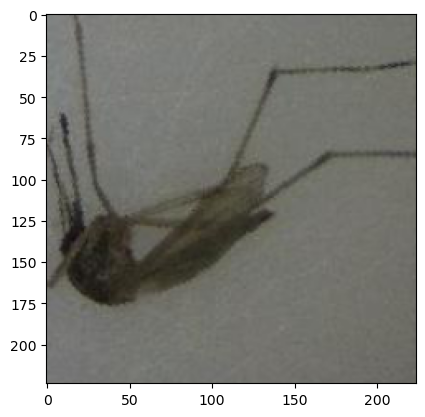

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imgs, labels = next(iter(trainLoader))

imshow(torchvision.utils.make_grid(imgs))

In [5]:
model = torchvision.models.resnet18(weights='DEFAULT')

# Froze other layers
for layer in model.parameters():
    layer.requires_grad = False

numIn = model.fc.in_features
model.fc = torch.nn.Sequential(OrderedDict(
    [
        ('lin1', nn.Linear(in_features=numIn, out_features=1000, bias=True)),
        ('lin2', nn.Linear(1000, 6, bias=True))
    ]
))

# unfroze the classification
for linear in model.fc.parameters():
    linear.requires_grad = True

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
CUDA_LAUNCH_BLOCKING=1

cuda = torch.device('cpu')
model = model.to(cuda)
model.train = True
earlyStop = EarlyStopping(patience=1, delta=15)
criterion = nn.CrossEntropyLoss()
# param_group = [{"params": [], 'weight_decay': 0.3}]
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.01)

numEpoch = 3
for epoch in range(0, numEpoch):
    correct = 0
    predList = []
    trueList = []
    for i, (image, label) in enumerate(iter(trainLoader)):
        image, label = image.to(cuda), label.to(cuda)
        with torch.cuda.amp.autocast(enabled=False):
            output = model(image)
            loss = criterion(output, label)

        predList.extend(output.cpu().max(dim=1)[1])
        trueList.extend(label.cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct += (output == label).float().sum()

    # Record data for ploting    
    acc = accuracy_score(trueList, predList)
    # Check learning progress

    print(f'Epoch: {epoch}, Accuracy: {acc}, loss: {loss.item()}')

    # validation phase
    valList = []
    trueList = []
    for k, (image, label) in enumerate(iter(valLoader)):
        image, label = image.to(cuda), label.to(cuda)
        with torch.cuda.amp.autocast(enabled=False):
            output = model(image)
            valLoss = criterion(output, label)
        valList.extend(output.cpu().max(dim=1)[1])
        trueList.extend(label.cpu())
    acc = accuracy_score(trueList, valList)

    
    print(f'Epoch: {epoch}, Accuracy: {acc}, validation loss: {valLoss}')
    print(classification_report(trueList, valList))

    earlyStop(valLoss, model)
    if earlyStop.early_stop:
        print(f'Early stopping due to no improvement after patient period of {earlyStop.patience} epochs')
        break

Epoch: 0, Accuracy: 0.15202702702702703, loss: 1.9443994760513306
Epoch: 0, Accuracy: 0.1463963963963964
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.00      0.00      0.00       165
           2       0.00      0.00      0.00       154
           3       0.15      1.00      0.26       130
           4       0.00      0.00      0.00       131
           5       0.00      0.00      0.00       155

    accuracy                           0.15       888
   macro avg       0.02      0.17      0.04       888
weighted avg       0.02      0.15      0.04       888



/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1, Accuracy: 0.16023166023166024, loss: 0.7417066693305969
Epoch: 1, Accuracy: 0.1858108108108108
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.19      1.00      0.31       165
           2       0.00      0.00      0.00       154
           3       0.00      0.00      0.00       130
           4       0.00      0.00      0.00       131
           5       0.00      0.00      0.00       155

    accuracy                           0.19       888
   macro avg       0.03      0.17      0.05       888
weighted avg       0.03      0.19      0.06       888

EarlyStopping counter: 1 out of 1
Early stopping due to no improvement after patient period of 1 epochs


/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Try predict

testSet = ImageFolder('./Datasets/Test', transform=imgTrans)
print(testSet.class_to_idx)

testLoader = torch.utils.data.DataLoader(testSet, shuffle=False, num_workers=4)

print(next(iter(testLoader)))

{'Aedes albopictus': 0, 'Aedes vexans': 1, 'Anopheles sinensis': 2, 'Culex pipiens': 3, 'Culex tritaeniorhynchus': 4, 'Non vectors': 5}
[tensor([[[[0.2941, 0.2941, 0.2902,  ..., 0.3176, 0.3137, 0.3137],
          [0.2941, 0.2941, 0.2902,  ..., 0.3176, 0.3216, 0.3176],
          [0.2902, 0.2902, 0.2902,  ..., 0.3137, 0.3176, 0.3137],
          ...,
          [0.2667, 0.2627, 0.2627,  ..., 0.2941, 0.3020, 0.2980],
          [0.2706, 0.2627, 0.2667,  ..., 0.2941, 0.2980, 0.2941],
          [0.2667, 0.2706, 0.2706,  ..., 0.2980, 0.3020, 0.2980]],

         [[0.3098, 0.3098, 0.3098,  ..., 0.3412, 0.3373, 0.3373],
          [0.3098, 0.3098, 0.3098,  ..., 0.3412, 0.3451, 0.3412],
          [0.3059, 0.3059, 0.3098,  ..., 0.3373, 0.3412, 0.3373],
          ...,
          [0.2863, 0.2824, 0.2824,  ..., 0.3176, 0.3216, 0.3176],
          [0.2902, 0.2824, 0.2863,  ..., 0.3137, 0.3176, 0.3137],
          [0.2863, 0.2902, 0.2902,  ..., 0.3176, 0.3216, 0.3176]],

         [[0.3059, 0.3059, 0.2980,  .

In [9]:
from pathlib import Path

# load the model
testModel = torchvision.models.resnet50(weights='DEFAULT')
testModel.fc = torch.nn.Sequential(OrderedDict(
        [
            ('lin1', nn.Linear(in_features=2048, out_features=1000, bias=True)),
            ('lin2', nn.Linear(1000, 6, bias=True))
        ]
    ))

modelPath = Path('/home/ubuntu/Share/MosquitoClassifierWebApp/CNN/savedModels/Thu May  4 04:20:06 2023/')

modelName = '_run:26_epoch:500_loss:0.0313185274953375_accuracy:1.0_epoch duration:11.824613094329834_run duration:10446.869837760925_lr:0.0001_batch_size:400_num_workers:4_device:cuda.pt'
testModel.load_state_dict(torch.load(Path(modelPath / modelName)))

<All keys matched successfully>

In [10]:
testModel.eval()
testModel.cuda()
optimizer = torch.optim.Adam(testModel.parameters(), lr=0.01)
predList = []
trueList = []

with torch.no_grad():
    for img, label in iter(testLoader):
        img = img.cuda()
        label = label.cuda()
        
        with torch.cuda.amp.autocast(enabled=False):
            output = testModel(img)

        predList.extend(output.cpu().max(dim=1)[1])
        trueList.extend(label.cpu())

        correct += (output.cpu() == label.cpu()).float().sum()

# Record data for ploting    
acc = accuracy_score(trueList, predList)

# Check learning progress

print(f'Epoch: {epoch}, Accuracy: {acc}')

print(classification_report(trueList, predList))

Epoch: 1, Accuracy: 0.9212837837837838
              precision    recall  f1-score   support

           0       0.97      0.88      0.93       500
           1       0.86      0.98      0.91       500
           2       0.87      0.99      0.92       500
           3       0.95      0.97      0.96       470
           4       0.97      0.75      0.85       495
           5       0.94      0.97      0.96       495

    accuracy                           0.92      2960
   macro avg       0.93      0.92      0.92      2960
weighted avg       0.93      0.92      0.92      2960

